In [ ]:
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import os
from sklearn.datasets import load_iris
from linearmodels.iv import IV2SLS
from statsmodels.formula.api import quantreg, wls
from statsmodels.iolib.summary2 import summary_col
from PIL import Image
from statsmodels.stats.stattools import durbin_watson
from collections import OrderedDict
from linearmodels.iv.results import compare
import doubleml as dml
from sklearn.ensemble import RandomForestRegressor
from sklearn.base import clone
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from doubleml import DoubleMLData, DoubleMLClusterData, DoubleMLPLIV
from doubleml.utils import DMLDummyRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import holidays
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from sklearn.inspection import permutation_importance
from xgboost import XGBRegressor
import xgboost as xgb
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import uniform, randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LassoCV

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-jncnydj4 because the default path (/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [ ]:
def calculate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return {'MAE': mae, 'RMSE': rmse, 'R²': r2}

def print_metrics(metrics, dataset_type):
    print(f"{dataset_type} Metrics:")
    print(f"  MAE: {metrics['MAE']:.4f}")
    print(f"  RMSE: {metrics['RMSE']:.4f}")
    print(f"  R²: {metrics['R²']:.4f}")

def evaluate_predictions(predictions, true_values, target_name="TargetVariable", time_values=None):
    """
    Evaluate model predictions against true values with metrics and visualizations.

    Args:
        predictions (pd.Series or np.ndarray): Model's predicted values.
        true_values (pd.Series or np.ndarray): True values from the dataset.
        target_name (str): Name of the target variable (for labeling plots and messages).
        time_values (pd.Series): Time values corresponding to the data for coloring.

    Returns:
        dict: Dictionary of metrics including MAE, RMSE, R², and percentage errors.
    """
    # Ensure inputs are aligned
    if isinstance(predictions, np.ndarray):
        predictions = pd.Series(predictions, index=true_values.index)

    # Calculate metrics
    metrics = calculate_metrics(true_values, predictions)

    # Print metrics
    print_metrics(metrics, dataset_type=f"Test - {target_name}")

    # Range of the target variable
    target_min = true_values.min()
    target_max = true_values.max()
    target_range = target_max - target_min
    print(f"{target_name} Range: Min = {target_min}, Max = {target_max}, Range = {target_range}")

    # Percentage errors
    mae_percentage = (metrics['MAE'] / target_range) * 100
    rmse_percentage = (metrics['RMSE'] / target_range) * 100

    print(f"MAE as percentage of range: {mae_percentage:.2f}%")
    print(f"RMSE as percentage of range: {rmse_percentage:.2f}%")

    # Extract years for coloring
    if time_values is not None:
        unique_years = time_values.unique()
        norm = mcolors.Normalize(vmin=min(unique_years), vmax=max(unique_years))
        cmap = cm.viridis
        colors = cmap(norm(time_values))
    else:
        colors = 'blue'  # Default color if no time_values provided

    # Visualizations
    # Scatter plot: Predicted vs Actual
    plt.scatter(true_values, predictions, c=colors, alpha=0.6)
    plt.plot([target_min, target_max], [target_min, target_max], 'r--', label='Perfect prediction')  # Perfect prediction line
    plt.title(f'Predicted vs. Actual {target_name}')
    plt.xlabel(f'Actual {target_name}')
    plt.ylabel(f'Predicted {target_name}')
    plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), label='Year')
    plt.legend()
    plt.show()

    # Residuals plot
    residuals = true_values - predictions
    plt.scatter(true_values, residuals, c=colors, alpha=0.6)
    plt.axhline(0, color='red', linestyle='--', label='Zero Residual')
    plt.title(f'Residuals vs. Actual {target_name}')
    plt.xlabel(f'Actual {target_name}')
    plt.ylabel('Residuals')
    plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), label='Year')
    plt.legend()
    plt.show()

    # Return metrics and percentages
    return {
        "Metrics": metrics,
        "MAE_Percentage": mae_percentage,
        "RMSE_Percentage": rmse_percentage
    }

In [ ]:
def evaluate_predictions_country(predictions, true_values, target_name="TargetVariable", country_values=None, title="Country"):
    """
    Evaluate model predictions against true values with metrics and visualizations.

    Args:
        predictions (pd.Series or np.ndarray): Model's predicted values.
        true_values (pd.Series or np.ndarray): True values from the dataset.
        target_name (str): Name of the target variable (for labeling plots and messages).
        country_values (pd.Series or np.ndarray): Country values corresponding to the data for coloring.

    Returns:
        dict: Dictionary of metrics including MAE, RMSE, R², and percentage errors.
    """
    import random
    from matplotlib.colors import ListedColormap

    # Ensure inputs are aligned
    if isinstance(predictions, np.ndarray):
        predictions = pd.Series(predictions, index=true_values.index)

    # Calculate metrics
    metrics = calculate_metrics(true_values, predictions)

    # Print metrics
    print_metrics(metrics, dataset_type=f"Test - {target_name}")

    # Range of the target variable
    target_min = true_values.min()
    target_max = true_values.max()
    target_range = target_max - target_min
    print(f"{target_name} Range: Min = {target_min}, Max = {target_max}, Range = {target_range}")

    # Percentage errors
    mae_percentage = (metrics['MAE'] / target_range) * 100
    rmse_percentage = (metrics['RMSE'] / target_range) * 100

    print(f"MAE as percentage of range: {mae_percentage:.2f}%")
    print(f"RMSE as percentage of range: {rmse_percentage:.2f}%")

    # Generate distinct colors for each unique country
    if country_values is not None:
        unique_countries = np.unique(country_values)
        num_countries = len(unique_countries)

        # Generate a list of random, unique colors
        random.seed(42)  # Ensures reproducibility
        colors = [
            (random.random(), random.random(), random.random())
            for _ in range(num_countries)
        ]
        cmap = ListedColormap(colors)

        # Map each country to a unique color
        color_mapping = {country: colors[idx] for idx, country in enumerate(unique_countries)}
        dot_colors = [color_mapping[country] for country in country_values]
    else:
        dot_colors = 'blue'  # Default color if no country_values provided
        color_mapping = None

    # Visualizations
    # Scatter plot: Predicted vs Actual
    plt.figure(figsize=(10, 6))
    plt.scatter(true_values, predictions, c=dot_colors, alpha=0.6)
    plt.plot([target_min, target_max], [target_min, target_max], 'r--', label='Perfect prediction')  # Perfect prediction line
    plt.title(f'Predicted vs. Actual {target_name}')
    plt.xlabel(f'Actual {target_name}')
    plt.ylabel(f'Predicted {target_name}')
    if country_values is not None:
        handles = [
            plt.Line2D([0], [0], marker='o', color=color_mapping[country], linestyle='', label=country)
            for country in unique_countries
        ]
        plt.legend(handles=handles, title=title, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

    # Residuals plot
    plt.figure(figsize=(10, 6))
    residuals = true_values - predictions
    plt.scatter(true_values, residuals, c=dot_colors, alpha=0.6)
    plt.axhline(0, color='red', linestyle='--', label='Zero Residual')
    plt.title(f'Residuals vs. Actual {target_name}')
    plt.xlabel(f'Actual {target_name}')
    plt.ylabel('Residuals')
    if country_values is not None:
        plt.legend(handles=handles, title=title, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

    # Return metrics and percentages
    return {
        "Metrics": metrics,
        "MAE_Percentage": mae_percentage,
        "RMSE_Percentage": rmse_percentage
    }

In [ ]:
def prepare_data_with_dummies_and_interactions(
    data,
    base_covariates=None,
    include_interactions=None,
    dependent_variable='consumption_normalized',
    include_lags=True  # 👈 New flag to include/exclude lags
):
    data = data.copy()
    data = data[data["PriceArea"] != "DE_AT_LU"]
    data['Time'] = pd.to_datetime(data['Time'])
    data['Year'] = data['Time'].dt.year
    data = data.sort_values(by='Time')
    data['Country'] = data['PriceArea']
    data['consumption_normalized'] = (
        data['ConsumptionValue'] /
        data.groupby(['Country', data['Time'].dt.year])['ConsumptionValue'].transform('mean')
    )
    data['consumption_norm_peak'] = (
        data['ConsumptionValue'] /
        data.groupby(['Country', 'Year'])['ConsumptionValue'].transform('max')
    )

    data['Total_Wind_Generation'] = (
        data['Wind_Offshore'].fillna(0) + data['Wind_Onshore'].fillna(0)
    )

    # Dummies
    data = pd.get_dummies(data, columns=['block'], drop_first=False)
    data = pd.get_dummies(data, columns=['PriceArea'], drop_first=False)
    price_area_columns = [col for col in data.columns if col.startswith('PriceArea_')]
    for col in price_area_columns:
        data[col] = data[col].astype(int)

    data['HourOfWeek'] = data['Time'].dt.dayofweek * 24 + data['Time'].dt.hour
    data = pd.get_dummies(data, columns=['HourOfWeek'], drop_first=False)

    data['Month'] = data['Time'].dt.month
    data = pd.get_dummies(data, columns=['Month'], drop_first=False)

    # Rolling features
    data['RollingMean24h'] = (
        data.groupby(['Country', 'Year'])[dependent_variable]
        .transform(lambda x: x.rolling(window=24, min_periods=12).mean())
    )
    data['RollingStd24h_Price'] = (
        data.groupby(['Country', 'Year'])['DayAheadPriceEUR']
        .transform(lambda x: x.rolling(window=24, min_periods=12).std())
    )

    # Weekend / spike flags
    data['IsWeekend'] = (data['Time'].dt.dayofweek >= 5).astype(int)
    price_threshold = data['DayAheadPriceEUR'].quantile(0.95)
    data['PriceSpike'] = (data['DayAheadPriceEUR'] > price_threshold).astype(int)

    # Step 2: Add interaction terms if specified
    interaction_covariates = []
    block_dummy_columns = [col for col in data.columns if col.startswith('block_')]

    if include_interactions:
        for block_col in block_dummy_columns:
            if 'block' in include_interactions:
                for interaction_col in include_interactions['block']:
                    interaction_term = f'{block_col}:{interaction_col}'
                    data[interaction_term] = data[block_col] * data[interaction_col]
                    interaction_covariates.append(interaction_term)

    # Step 3: Optionally add lagged features
    lag_features = []
    if include_lags:
        data['Lag1_Consumption'] = data.groupby('Country')[dependent_variable].shift(1)
        data['Lag24_Consumption'] = data.groupby('Country')[dependent_variable].shift(24)
        data['Lag168_Consumption'] = data.groupby('Country')[dependent_variable].shift(168)
        lag_features = ['Lag1_Consumption', 'Lag24_Consumption', 'Lag168_Consumption']

    # Step 4: Define covariates
    if base_covariates is None:
        base_covariates = []

    engineered_features = ['RollingMean24h', 'RollingStd24h_Price', 'IsWeekend', 'PriceSpike']
    all_features = base_covariates + engineered_features + lag_features

    for feat in all_features:
        if feat not in base_covariates:
            base_covariates.append(feat)

    covariates = list(set(base_covariates + interaction_covariates +
                          [col for col in data.columns if col.startswith('PriceArea_')] +
                          [col for col in data.columns if col.startswith('HourOfWeek_')] +
                          [col for col in data.columns if col.startswith('Month_')]))

    covariates = [col for col in covariates if not (col.startswith('block_') and ':' not in col)]

    # Drop NaNs from rolling/lags
    data = data.dropna()

    return data, covariates

In [ ]:
def prepare_data_lags_with_iv_lags(
    data,
    base_covariates=None,
    include_interactions=None,
    dependent_variable='consumption_normalized',
    include_lags=True,
    lag_variable='Total_Wind_Generation',
    n_lags=50
):
    data = data.copy()
    data = data[data["PriceArea"] != "DE_AT_LU"]
    data['Time'] = pd.to_datetime(data['Time'])
    data['Year'] = data['Time'].dt.year
    data = data.sort_values(by='Time')
    data['Country'] = data['PriceArea']
    data['consumption_normalized'] = (
        data['ConsumptionValue'] /
        data.groupby(['Country', data['Time'].dt.year])['ConsumptionValue'].transform('mean')
    )
    data['consumption_norm_peak'] = (
        data['ConsumptionValue'] /
        data.groupby(['Country', 'Year'])['ConsumptionValue'].transform('max')
    )

    data['Total_Wind_Generation'] = (
        data['Wind_Offshore'].fillna(0) + data['Wind_Onshore'].fillna(0)
    )

    # Dummies
    data = pd.get_dummies(data, columns=['block'], drop_first=False)
    data = pd.get_dummies(data, columns=['PriceArea'], drop_first=False)
    price_area_columns = [col for col in data.columns if col.startswith('PriceArea_')]
    for col in price_area_columns:
        data[col] = data[col].astype(int)

    data['HourOfWeek'] = data['Time'].dt.dayofweek * 24 + data['Time'].dt.hour
    data = pd.get_dummies(data, columns=['HourOfWeek'], drop_first=False)

    data['Month'] = data['Time'].dt.month
    data = pd.get_dummies(data, columns=['Month'], drop_first=False)

    # Rolling features
    data['RollingMean24h'] = (
        data.groupby(['Country', 'Year'])[dependent_variable]
        .transform(lambda x: x.rolling(window=24, min_periods=12).mean())
    )
    data['RollingStd24h_Price'] = (
        data.groupby(['Country', 'Year'])['DayAheadPriceEUR']
        .transform(lambda x: x.rolling(window=24, min_periods=12).std())
    )

    # Weekend / spike flags
    data['IsWeekend'] = (data['Time'].dt.dayofweek >= 5).astype(int)

    # Step 2: Add interaction terms if specified
    interaction_covariates = []
    block_dummy_columns = [col for col in data.columns if col.startswith('block_')]

    if include_interactions:
        for block_col in block_dummy_columns:
            if 'block' in include_interactions:
                for interaction_col in include_interactions['block']:
                    interaction_term = f'{block_col}:{interaction_col}'
                    data[interaction_term] = data[block_col] * data[interaction_col]
                    interaction_covariates.append(interaction_term)

    # Step 3: Add lagged instruments
    lagged_iv_columns = []
    if include_lags:
        for lag in range(1, n_lags + 1):
            lag_col = f'{lag_variable}_lag{lag}'
            data[lag_col] = (
                data.groupby('Country')[lag_variable]
                .transform(lambda x: x.shift(lag))
            )
            lagged_iv_columns.append(lag_col)

    # Create full covariate list
    covariates = list(set(base_covariates + interaction_covariates +
                          [col for col in data.columns if col.startswith('PriceArea_')] +
                          [col for col in data.columns if col.startswith('HourOfWeek_')] +
                          [col for col in data.columns if col.startswith('Month_')] +
                          lagged_iv_columns))

    covariates = [col for col in covariates if not (col.startswith('block_') and ':' not in col)]
    endogenous_variable = 'DayAheadPriceEUR'
    instrument_variables = ['Total_Wind_Generation']

    key_variables = [dependent_variable, endogenous_variable] + instrument_variables + covariates
    filtered_processed_data = data.dropna(subset=key_variables)

    return filtered_processed_data, covariates

In [ ]:
def dml_rolling_window(filtered_data, base_covariates, manual_params_l=None, manual_params_r = None, manual_params_m=None, param_dist_xgb=None, param_dist_xgb_r=None, param_dist_xgb_m=None, dependent_variable = 'consumption_normalized'):

    data = filtered_data.copy()

    covariates = base_covariates.copy()


    # Initialize lists to collect predictions and time indices
    predictions_ml_l = []
    predictions_ml_r = []
    predictions_ml_m = []
    time_indices = []
    train_predictions = []
    train_actuals = []
    test_predictions = []
    test_actuals = []
    feature_importances_per_window = []
    fold_metrics = []
    test_years = []
    fold_feature_importance_df = []
    fold_coefficients = []



    train_test_pairs = [
    (2015, 2016, 2017),
    (2016, 2017, 2018),
    (2017, 2018, 2019),
    (2018, 2019, 2020),
    (2019, 2020, 2021),
    (2020, 2021, 2022),
    (2021, 2022, 2023),
    (2022, 2023, 2024)]


    def tune_xgb_model(X, y, param_dist_xgb):
        tscv = TimeSeriesSplit(n_splits=3)
        model = xgb.XGBRegressor(objective="reg:squarederror", tree_method="hist", eval_metric="rmse")
        grid_search = GridSearchCV(model, param_dist_xgb, cv=tscv, n_jobs=-1)
        grid_search.fit(X, y)
        return grid_search.best_params_

    best_params_xgb = None  # Store best params from first window
    best_params_xgb_treat = None
    best_params_xgb_inst = None
    lasso_param = None

    data['Year'] = data['Time'].dt.year
    year_to_indices = data.groupby('Year').indices



    for train_start, train_end, test_year in train_test_pairs:
        train_indices = []
        for y in range(train_start, train_end + 1):
            if y in year_to_indices:
                train_indices.extend(year_to_indices[y])

        test_indices = year_to_indices.get(test_year, [])

        if len(train_indices) == 0 or len(test_indices) == 0:
            print(f"Skipping test year {test_year} due to insufficient data.")
            continue

        train_data = data.iloc[train_indices]
        test_data = data.iloc[test_indices]



        print(f"\nTest Year: {test_year} | Training Years: {train_start} to {train_end}")
        print(f"Train samples: {len(train_indices)} | Test samples: {len(test_indices)}")


        X_train = train_data[covariates]
        y_train_ml_l = train_data[dependent_variable]
        d_train_ml_r = train_data['DayAheadPriceEUR']
        z_train_ml_m_1 = train_data['Total_Wind_Generation']


        if best_params_xgb is None and manual_params_l is None:
            best_params_xgb = tune_xgb_model(X_train, y_train_ml_l, param_dist_xgb)
            print("Best L Parameters:", best_params_xgb)

        if best_params_xgb_treat is None and manual_params_r is None:
            best_params_xgb_treat = tune_xgb_model(X_train, d_train_ml_r, param_dist_xgb_r)
            print("Best R Parameters:", best_params_xgb_treat)


        if best_params_xgb_inst is None and manual_params_m is None:
            best_params_xgb_inst = tune_xgb_model(X_train, z_train_ml_m_1, param_dist_xgb_m)
            print("Best M Parameters:", best_params_xgb_inst)

        learner_l = xgb.XGBRegressor(**(manual_params_l if manual_params_l else best_params_xgb))
        learner_r = xgb.XGBRegressor(**(manual_params_r if manual_params_r else best_params_xgb_treat))
        learner_m = xgb.XGBRegressor(**(manual_params_m if manual_params_m else best_params_xgb_inst))
            # Train each model on the training set (fixed window)
        learner_l.fit(X_train, y_train_ml_l)
        learner_r.fit(X_train, d_train_ml_r)
        learner_m.fit(X_train, z_train_ml_m_1)

        feature_importances_per_window.append(learner_l.feature_importances_)

            # Predict on the test set (next year)
        X_test = test_data[covariates]
        y_test_ml_l = test_data[dependent_variable]
        d_test_ml_r = test_data['DayAheadPriceEUR']
        z_test_ml_m_1 = test_data['Total_Wind_Generation']
        pred_l = learner_l.predict(X_test)
        pred_r = learner_r.predict(X_test)
        pred_m = learner_m.predict(X_test)

            # Predict on the train set (next year)
        train_predictions.extend(learner_l.predict(X_train))
        train_actuals.extend(y_train_ml_l)
        test_predictions.extend(learner_l.predict(X_test))
        test_actuals.extend(y_test_ml_l)

            # Append predictions and indices to the lists
        predictions_ml_l.extend(pred_l)
        predictions_ml_r.extend(pred_r)
        predictions_ml_m.extend(pred_m)
        time_indices.extend(test_data.index.tolist())

        plt.figure(figsize=(12, 4))
        plt.plot(test_actuals[:500], label='Actual')
        plt.plot(test_predictions[:500], label='Predicted')
        plt.title("First 500 test predictions vs actuals")
        plt.legend()
        plt.show()

        fold_mae = mean_absolute_error(y_test_ml_l, pred_l)
        fold_rmse = mean_squared_error(y_test_ml_l, pred_l, squared=False)
        fold_r2 = r2_score(y_test_ml_l, pred_l)
        fold_rr = r2_score(d_test_ml_r, pred_r)
        fold_rz = r2_score(z_test_ml_m_1, pred_m)
        print("Test error l:", fold_r2)
        print("Test error r:", fold_rr)
        print("Test error m:", fold_rz)

        fold_metrics.append({
            'Test Year': test_year,
            'MAE': fold_mae,
            'RMSE': fold_rmse,
            'R2': fold_r2
        })
        test_years.append(test_year)

        fold_feature_importance_df.append(pd.DataFrame({
            'Feature': covariates,
            'Importance': learner_l.feature_importances_,
            'Year': test_year
        }))

        dml_data_fold = dml.DoubleMLClusterData(
            test_data.reset_index(drop=True),
            y_col=dependent_variable,
            d_cols='DayAheadPriceEUR',
            z_cols='Total_Wind_Generation',
            x_cols=covariates,
            cluster_cols=['Country']
        )

        dml_fold = dml.DoubleMLPLIV(dml_data_fold, dml.utils.DMLDummyRegressor(), dml.utils.DMLDummyRegressor(), dml.utils.DMLDummyRegressor())
        dml_fold.fit(external_predictions={
            'DayAheadPriceEUR': {
                'ml_l': pred_l.reshape(-1, 1),
                'ml_r': pred_r.reshape(-1, 1),
                'ml_m': pred_m.reshape(-1, 1)
            }
        })
        fold_coefficients.append({
            'Year': test_year,
            'coef': dml_fold.coef,
            'se': dml_fold.se,
            't': dml_fold.t_stat,
            'p': dml_fold.pval,
        })


    # Calculate metrics for the entire model
    train_mae = mean_absolute_error(train_actuals, train_predictions)
    train_rmse = mean_squared_error(train_actuals, train_predictions, squared=False)
    train_r2 = r2_score(train_actuals, train_predictions)

    test_mae = mean_absolute_error(test_actuals, test_predictions)
    test_rmse = mean_squared_error(test_actuals, test_predictions, squared=False)
    test_r2 = r2_score(test_actuals, test_predictions)

    print("Overall Train Metrics:")
    print(f"MAE: {train_mae}, RMSE: {train_rmse}, R²: {train_r2}")

    print("Overall Test Metrics:")
    print(f"MAE: {test_mae}, RMSE: {test_rmse}, R²: {test_r2}")



    feature_importances_array = np.array(feature_importances_per_window)
    mean_importances = feature_importances_array.mean(axis=0)
    std_importances = feature_importances_array.std(axis=0)
    importance_df = pd.DataFrame({
        'Feature': covariates,
        'Mean Importance': mean_importances,
        'Std Importance': std_importances
    }).sort_values(by='Mean Importance', ascending=False)


    # Convert predictions lists to numpy arrays
    filtered_data = data.loc[data.index.isin(time_indices)].copy()

    #### predictins dataset? original dataset?

    predictions_ml_l = np.array(predictions_ml_l).reshape(-1, 1)
    predictions_ml_r = np.array(predictions_ml_r).reshape(-1, 1)
    predictions_ml_m = np.array(predictions_ml_m).reshape(-1, 1)


    pred_dict = {
        'DayAheadPriceEUR': {
            'ml_l': predictions_ml_l,
            'ml_r': predictions_ml_r,
            'ml_m': predictions_ml_m
        }
    }

    # Initialize DoubleML data object
    obj_dml_data = dml.DoubleMLClusterData(
        filtered_data,
        y_col=dependent_variable,
        d_cols='DayAheadPriceEUR',
        z_cols='Total_Wind_Generation',  # Use original instruments (not the lags) for DoubleML
        x_cols=covariates,
        cluster_cols=['Country']
    )
    # Use dummy regressors for DoubleML
    ml_l = dml.utils.DMLDummyRegressor()
    ml_m = dml.utils.DMLDummyRegressor()
    ml_r = dml.utils.DMLDummyRegressor()

    # Initialize and fit DoubleML with external predictions
    dml_pliv_obj = dml.DoubleMLPLIV(obj_dml_data, ml_l, ml_m, ml_r)
    dml_pliv_obj.fit(external_predictions=pred_dict)

    print(dml_pliv_obj)
    filtered_data["Prrediction"] = dml_pliv_obj.predictions["ml_l"].ravel()
    filtered_data["Residuals"] = dml_pliv_obj.predictions["ml_l"].ravel() - filtered_data[dependent_variable]
    importance_all_folds_df = pd.concat(fold_feature_importance_df, ignore_index=True)
    fold_metrics_df = pd.DataFrame(fold_metrics)



    return dml_pliv_obj, filtered_data, importance_df, fold_metrics_df, importance_all_folds_df, fold_coefficients

In [ ]:
data_1 = pd.read_csv('/workspace/new_data/filtered_data_with_holidays_updated.csv', index_col=0)
data_1

,Unnamed: 0,Time,PriceArea,ConsumptionValue,DayAheadPriceEUR,WeatherWindSpeed,WeatherTemperature,Year,Month,Day,...,YearMonthDay,Price_Area,Price_gas,Price_coal,Price_EUA,IsHoliday,B16,B18,B19,Price_gas_ttf
Unnamed: 0.1,,,,,,,,,,,,,,,,,,,,,
0.0,0.0,2015-01-01 01:00:00,CH,7654.0,38.08,3.647062,267.706482,2015.0,1.0,1.0,...,2015-01-01,cegh,20.650,66.7,7.34,1.0,NaN,NaN,NaN,NaN
1.0,17.0,2015-01-01 01:00:00,SK,2728.0,22.06,3.991796,265.239655,2015.0,1.0,1.0,...,2015-01-01,cz,20.650,66.7,7.34,1.0,NaN,NaN,NaN,NaN
2.0,16.0,2015-01-01 01:00:00,SI,1045.0,22.20,4.172168,265.189819,2015.0,1.0,1.0,...,2015-01-01,cegh,20.650,66.7,7.34,1.0,NaN,NaN,NaN,NaN
3.0,15.0,2015-01-01 01:00:00,PT,5124.0,47.33,6.417383,279.455658,2015.0,1.0,1.0,...,2015-01-01,cz,20.650,66.7,7.34,1.0,NaN,NaN,NaN,NaN
4.0,10.0,2015-01-01 01:00:00,DK_2,1305.0,16.04,10.561893,276.635590,2015.0,1.0,1.0,...,2015-01-01,etf,20.650,66.7,7.34,1.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NaN,NaN,2025-01-01 00:00:00,SE_2,1791.0,3.69,3.096981,262.690735,2025.0,1.0,1.0,...,2025-01-01 00:00:00,etf,48.889,114.5,73.00,NaN,0.0,NaN,243.0,NaN
NaN,NaN,2025-01-01 00:00:00,SE_3,9658.0,2.47,7.332158,272.276581,2025.0,1.0,1.0,...,2025-01-01 00:00:00,etf,48.889,114.5,73.00,NaN,0.0,NaN,2131.0,NaN
NaN,NaN,2025-01-01 00:00:00,SE_4,2146.0,2.04,14.230573,276.445221,2025.0,1.0,1.0,...,2025-01-01 00:00:00,etf,48.889,114.5,73.00,NaN,1.0,NaN,1849.0,NaN


In [ ]:
rows_to_remove = [
    ("2022-02-10 20:00:00", "SE_2"),
    ("2022-02-10 21:00:00", "SE_2"),
    ("2022-02-10 22:00:00", "SE_2"),
    ("2020-02-27 09:00:00", "DK_2"),
    ("2024-10-22 14:00:00", "DK_2"),
    ("2017-05-08 07:00:00", "DK_1"),
    ("2018-02-06 12:00:00", "DK_2"),
    ("2021-12-20 18:00:00", "IT_CALA"),
    ("2021-12-20 16:00:00", "IT_CALA"),
    ("2021-12-21 09:00:00", "IT_CALA"),
    ("2021-12-17 18:00:00", "IT_CALA"),
    ("2021-12-20 08:00:00", "IT_CALA"),
    ("2021-12-20 15:00:00", "IT_CALA"),
    ("2021-12-21 12:00:00", "IT_CALA"),
    ("2022-01-25 08:00:00", "IT_CALA"),
    ("2021-12-21 11:00:00", "IT_CALA"),
    ("2021-12-20 19:00:00", "IT_CALA"),
    ("2017-05-08 06:00:00", "DK_1"),
    ("2021-12-21 08:00:00", "IT_CALA"),
    ("2021-11-29 16:00:00", "IT_CALA"),
    ("2021-12-17 16:00:00", "IT_CALA")
]
data_1['Time'] = pd.to_datetime(data_1['Time'])
for time_str, country in rows_to_remove:
    timestamp = pd.to_datetime(time_str)
    data_1 = data_1[~((data_1['Time'] == timestamp) & (data_1['PriceArea'] == country))]

## CIV(Wt | Pt → Dt | Wt−1,...,Wt−50)

In [ ]:
processed_data, covariates = prepare_data_lags_with_iv_lags(
    data_1,
    base_covariates=['Price_gas', 'Price_coal', 'Price_EUA'],
    include_interactions={'block': ['tempbin', 'tempbin2', 'Solar_MWh']},
    dependent_variable = 'consumption_normalized'
)

<ipython-input-5-d39b28252388>:72: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[lag_col] = (
<ipython-input-5-d39b28252388>:72: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[lag_col] = (
<ipython-input-5-d39b28252388>:72: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[lag_col] = (
<ipy

In [ ]:
covariates

['Total_Wind_Generation_lag26',
 'HourOfWeek_38',
 'block_2.0:Solar_MWh',
 'PriceArea_LT',
 'Total_Wind_Generation_lag4',
 'Total_Wind_Generation_lag25',
 'HourOfWeek_20',
 'HourOfWeek_114',
 'HourOfWeek_125',
 'Total_Wind_Generation_lag38',
 'PriceArea_BG',
 'block_2.0:tempbin',
 'HourOfWeek_54',
 'Total_Wind_Generation_lag46',
 'HourOfWeek_6',
 'Price_gas',
 'HourOfWeek_87',
 'HourOfWeek_15',
 'HourOfWeek_163',
 'Total_Wind_Generation_lag3',
 'PriceArea_FI',
 'Month_4',
 'HourOfWeek_51',
 'HourOfWeek_3',
 'HourOfWeek_61',
 'Total_Wind_Generation_lag50',
 'PriceArea_PT',
 'HourOfWeek_4',
 'HourOfWeek_42',
 'HourOfWeek_146',
 'PriceArea_IT_SUD',
 'HourOfWeek_82',
 'Total_Wind_Generation_lag28',
 'HourOfWeek_79',
 'block_1.0:tempbin2',
 'HourOfWeek_156',
 'block_1.0:tempbin',
 'Month_5',
 'HourOfWeek_108',
 'Total_Wind_Generation_lag44',
 'HourOfWeek_158',
 'HourOfWeek_74',
 'Month_8',
 'HourOfWeek_9',
 'Total_Wind_Generation_lag42',
 'HourOfWeek_134',
 'block_4.0:tempbin2',
 'Total_Win

In [ ]:
processed_data = processed_data[processed_data['Time'].dt.year != 2025]

In [ ]:
manual_params_l = {
    'learning_rate': 0.02,  # Slightly lower to smooth fit
    'max_depth': 5,         # Shallower trees reduce overfitting
    'n_estimators': 400,    # Faster convergence, lower complexity
    'subsample': 0.8,       # Adds randomness (boost generalization)
    'colsample_bytree': 0.8
}

manual_params_r = {
    'learning_rate': 0.01,
    'max_depth': 3,         # More regularization on treatment model
    'n_estimators': 300,    # Slightly fewer to prevent overfitting noise
    'subsample': 0.7,
    'colsample_bytree': 0.8,
    'reg_alpha': 0.1,       # L1 regularization
    'reg_lambda': 0.5       # L2 regularization
}

manual_params_m = {
    'learning_rate': 0.01,
    'max_depth': 4,
    'n_estimators': 400,
    'subsample': 0.9,
    'colsample_bytree': 0.9
}



Test Year: 2017 | Training Years: 2015 to 2016
Train samples: 400618 | Test samples: 209955


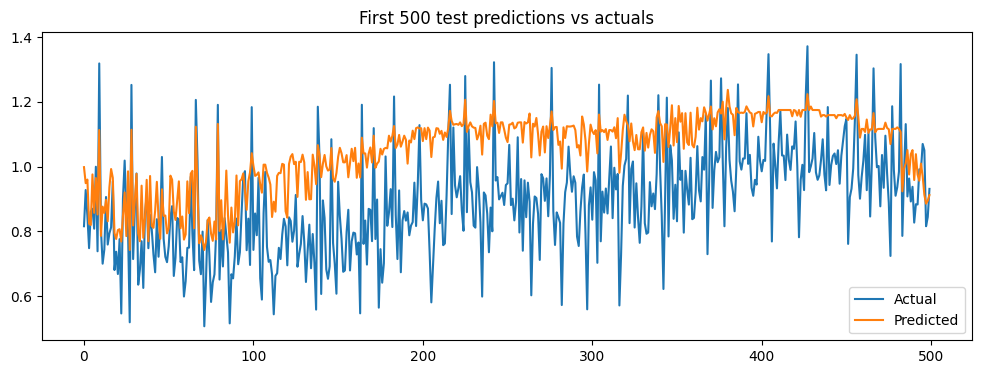

Test error l: 0.637049119668714
Test error r: 0.14989795741773615
Test error m: 0.993864525986336

Test Year: 2018 | Training Years: 2016 to 2017
Train samples: 412247 | Test samples: 203208


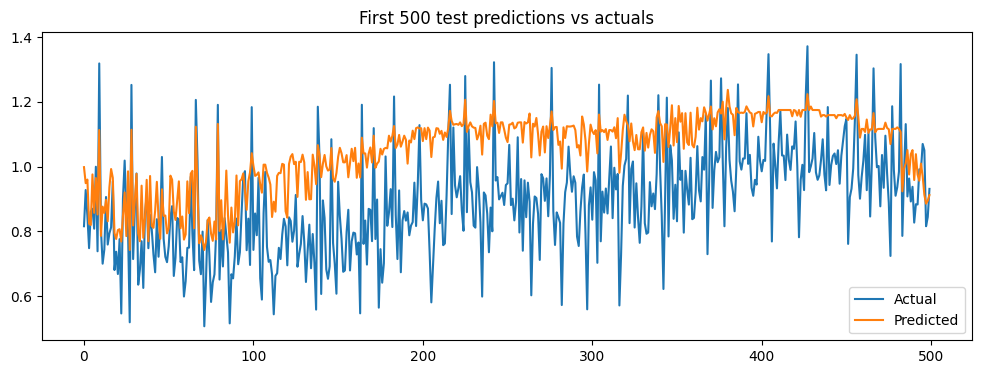

Test error l: 0.5188251791231351
Test error r: 0.0006277083132628647
Test error m: 0.993099109154007

Test Year: 2019 | Training Years: 2017 to 2018
Train samples: 413163 | Test samples: 221172


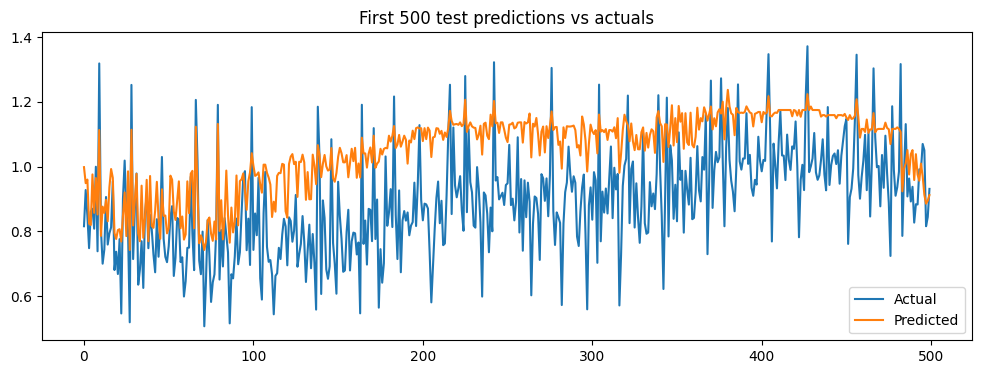

Test error l: 0.6190747711010229
Test error r: 0.18397563427222274
Test error m: 0.9950410322095578

Test Year: 2020 | Training Years: 2018 to 2019
Train samples: 424380 | Test samples: 234675


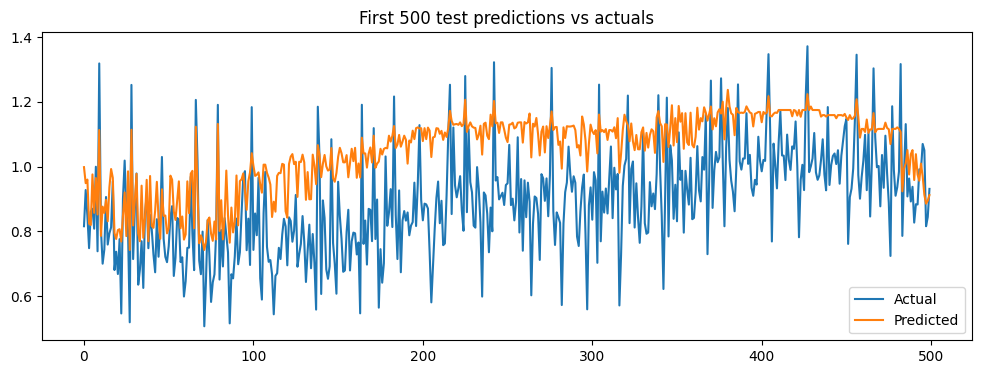

Test error l: 0.6135134312235667
Test error r: 0.0406827161700658
Test error m: 0.9950399983685042

Test Year: 2021 | Training Years: 2019 to 2020
Train samples: 455847 | Test samples: 252009


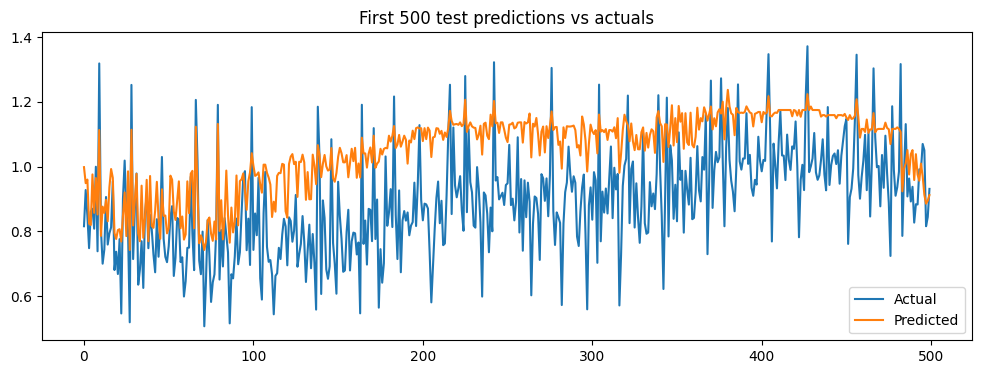

Test error l: 0.5632126935196459
Test error r: -0.6961929885333062
Test error m: 0.9948007174002151

Test Year: 2022 | Training Years: 2020 to 2021
Train samples: 486684 | Test samples: 282857


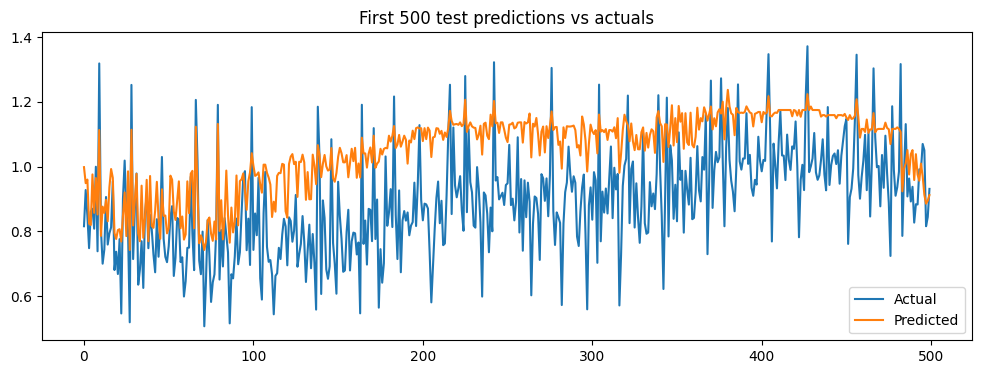

Test error l: 0.46271966853830226
Test error r: 0.35025770725950645
Test error m: 0.9945770597068412

Test Year: 2023 | Training Years: 2021 to 2022
Train samples: 534866 | Test samples: 289771


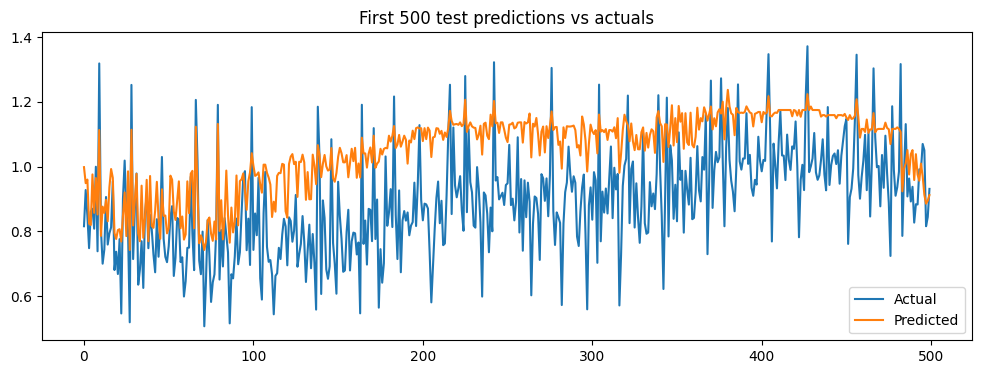

Test error l: 0.5322659834334402
Test error r: 0.17714251220609023
Test error m: 0.9944140092077843

Test Year: 2024 | Training Years: 2022 to 2023
Train samples: 572628 | Test samples: 303966


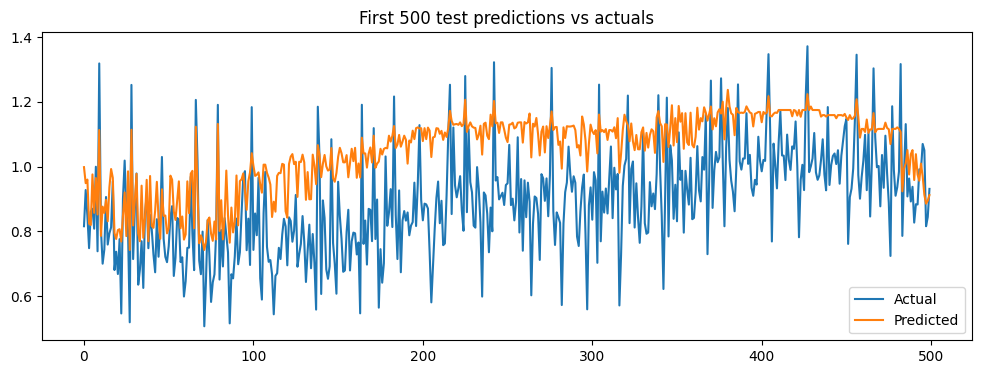

Test error l: 0.5422829052327023
Test error r: 0.13905780598509931
Test error m: 0.993914807737024
Overall Train Metrics:
MAE: 0.08740420746565544, RMSE: 0.11208275564333038, R²: 0.6575961966054914
Overall Test Metrics:
MAE: 0.10062153068203014, RMSE: 0.13008049134102406, R²: 0.5550189242455876
================== DoubleMLPLIV Object ==================

------------------ Data summary      ------------------
Outcome variable: consumption_normalized
Treatment variable(s): ['DayAheadPriceEUR']
Cluster variable(s): ['Country']
Covariates: ['Total_Wind_Generation_lag26', 'HourOfWeek_38', 'block_2.0:Solar_MWh', 'PriceArea_LT', 'Total_Wind_Generation_lag4', 'Total_Wind_Generation_lag25', 'HourOfWeek_20', 'HourOfWeek_114', 'HourOfWeek_125', 'Total_Wind_Generation_lag38', 'PriceArea_BG', 'block_2.0:tempbin', 'HourOfWeek_54', 'Total_Wind_Generation_lag46', 'HourOfWeek_6', 'Price_gas', 'HourOfWeek_87', 'HourOfWeek_15', 'HourOfWeek_163', 'Total_Wind_Generation_lag3', 'PriceArea_FI', 'Month_4', 'Ho

In [ ]:
dml_pliv_obj_lags_1, filtered_data_lags_1, importance_df_lags_1, fold_metrics_df_lags_1, importance_all_folds_df_lags_1, fold_coefficients_lags_1 = dml_rolling_window(processed_data,
                                                                                                                             covariates,
                                                                                                                             dependent_variable = 'consumption_normalized',
                                                                                                                             manual_params_l=manual_params_l,
                                                                                                                             manual_params_r=manual_params_r,
                                                                                                                             manual_params_m=manual_params_m)


In [ ]:
filtered_data_lags_1.to_csv("second_model_lags.csv", index=False)
importance_df_lags_1.to_csv("second_model_lags_importance_df.csv", index=False)
fold_coefficients_lags_1 = pd.DataFrame(fold_coefficients_lags_1)
fold_coefficients_lags_1.to_csv("second_model_lags_fold_coefficients.csv", index=False)

In [ ]:
covariates_regression = [var for var in covariates if var not in ['HourOfWeek_0', 'Month_1']]

In [ ]:
outcome_var = 'consumption_normalized'
treatment_var = ['DayAheadPriceEUR']
instrument_vars = ['Total_Wind_Generation']
cluster_var = 'Country'

# Prepare matrices
Y = filtered_data_lags[outcome_var]
D = filtered_data_lags[treatment_var]
Z = filtered_data_lags[instrument_vars]
W = filtered_data_lags[covariates_regression]

# Fit the IV model
iv_model_check_filter = IV2SLS(dependent=Y, exog=W, endog=D, instruments=Z).fit(cov_type='clustered', clusters=filtered_data_lags[cluster_var])

# Summary of results
print(iv_model_check_filter.summary)

                            IV-2SLS Estimation Summary                            
Dep. Variable:     consumption_normalized   R-squared:                      0.5687
Estimator:                        IV-2SLS   Adj. R-squared:                 0.5686
No. Observations:                 1997613   F-statistic:                 2.041e+15
Date:                    Sun, Apr 06 2025   P-value (F-stat)                0.0000
Time:                            18:31:54   Distribution:                chi2(288)
Cov. Estimator:                 clustered                                         
                                                                                  
                                      Parameter Estimates                                      
                             Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-----------------------------------------------------------------------------------------------
Total_Wind_Generation_lag26 -4.801e-07  5.613e-0

Test - consumption_normalized Metrics:
  MAE: 0.0856
  RMSE: 0.1168
  R²: 0.6413
consumption_normalized Range: Min = 0.0, Max = 2.7072245076569836, Range = 2.7072245076569836
MAE as percentage of range: 3.16%
RMSE as percentage of range: 4.31%


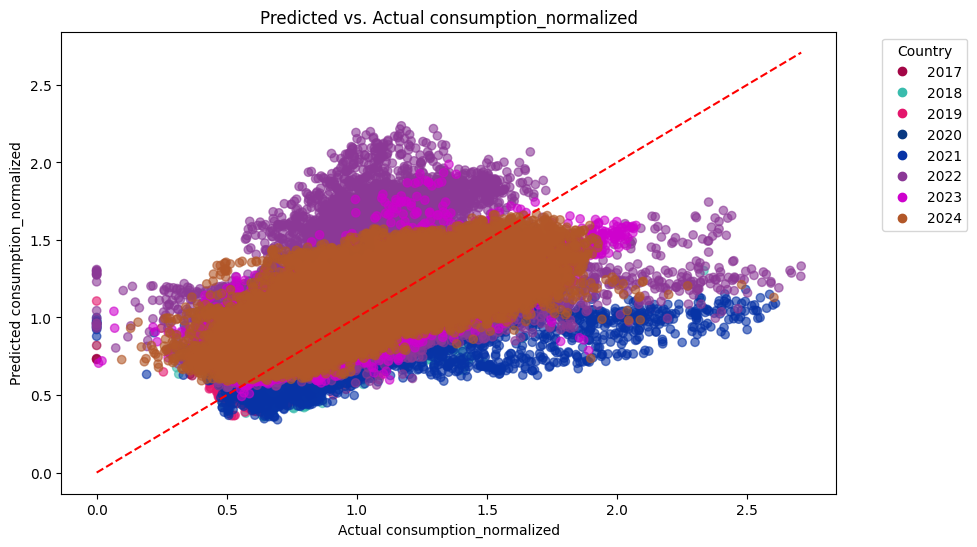

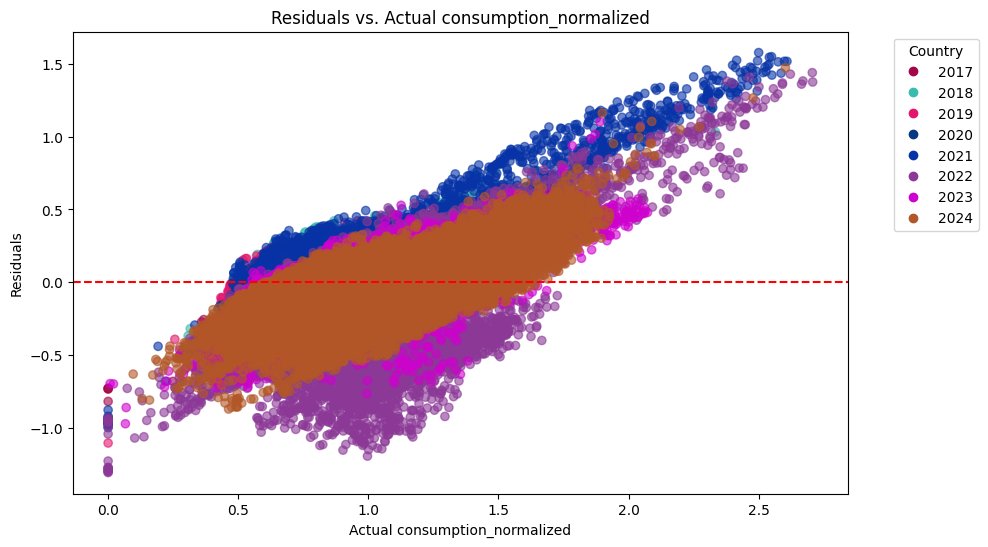

In [ ]:
result = evaluate_predictions_country(
    predictions=dml_pliv_obj_lags.predictions['ml_l'].ravel(),
    true_values=filtered_data_lags['consumption_normalized'],
    target_name="consumption_normalized",
    country_values=filtered_data_lags['Year']  # Use the Country column
)

In [ ]:
most_important_features = importance_df_lags.sort_values(by='Mean Importance', ascending=False)
most_important_features.head(90)

,Feature,Mean Importance,Std Importance
228,HourOfWeek_149,0.038037,0.006185
34,block_1.0:tempbin2,0.028703,0.003185
202,HourOfWeek_150,0.028141,0.003665
8,HourOfWeek_125,0.024627,0.002637
70,block_6.0:tempbin2,0.019616,0.001600
...,...,...,...
191,HourOfWeek_88,0.003132,0.000971
6,HourOfWeek_20,0.003094,0.000537
274,HourOfWeek_145,0.002968,0.000458
182,HourOfWeek_57,0.002928,0.000804


## Importance

In [ ]:
importance_df_lags = pd.read_csv("second_model_lags_importance_df.csv")

In [ ]:
important_features = importance_df_lags[importance_df_lags['Mean Importance'] > 0.001]['Feature']
important_features

0                block_1.0:tempbin
1               block_6.0:tempbin2
2               block_1.0:tempbin2
3                block_6.0:tempbin
4                          Month_1
                  ...             
109                   PriceArea_BG
110                PriceArea_DE_LU
111                   HourOfWeek_1
112              PriceArea_IT_SARD
113    Total_Wind_Generation_lag16
Name: Feature, Length: 114, dtype: object

In [ ]:
important_features = importance_df_lags[importance_df_lags['Mean Importance'] > 0.0004]['Feature'].tolist()
important_features

['block_1.0:tempbin',
 'block_6.0:tempbin2',
 'block_1.0:tempbin2',
 'block_6.0:tempbin',
 'Month_1',
 'Month_2',
 'HourOfWeek_149',
 'Month_5',
 'HourOfWeek_150',
 'HourOfWeek_125',
 'HourOfWeek_151',
 'Month_12',
 'HourOfWeek_157',
 'HourOfWeek_158',
 'HourOfWeek_156',
 'HourOfWeek_159',
 'HourOfWeek_126',
 'HourOfWeek_153',
 'HourOfWeek_155',
 'HourOfWeek_154',
 'HourOfWeek_164',
 'Month_3',
 'HourOfWeek_140',
 'HourOfWeek_152',
 'block_3.0:tempbin',
 'HourOfWeek_56',
 'HourOfWeek_69',
 'HourOfWeek_132',
 'HourOfWeek_80',
 'HourOfWeek_134',
 'Price_gas',
 'HourOfWeek_32',
 'HourOfWeek_45',
 'HourOfWeek_160',
 'HourOfWeek_133',
 'Month_4',
 'HourOfWeek_21',
 'HourOfWeek_93',
 'HourOfWeek_104',
 'block_5.0:tempbin',
 'HourOfWeek_131',
 'HourOfWeek_135',
 'HourOfWeek_55',
 'Price_coal',
 'HourOfWeek_163',
 'HourOfWeek_79',
 'HourOfWeek_31',
 'HourOfWeek_130',
 'HourOfWeek_0',
 'Price_EUA',
 'HourOfWeek_144',
 'HourOfWeek_65',
 'HourOfWeek_89',
 'HourOfWeek_167',
 'HourOfWeek_41',
 'Hou


Test Year: 2017 | Training Years: 2015 to 2016
Train samples: 400618 | Test samples: 209955


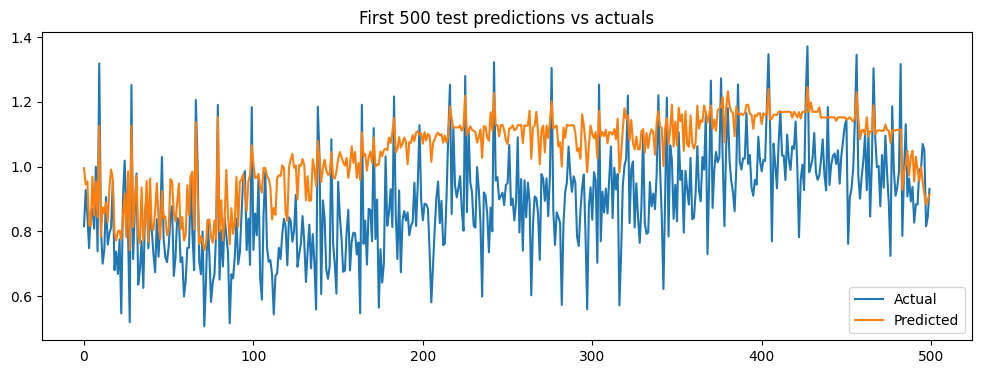

Test error l: 0.639185744060234
Test error r: 0.15556575593030375
Test error m: 0.9383282043696095

Test Year: 2018 | Training Years: 2016 to 2017
Train samples: 412247 | Test samples: 203208


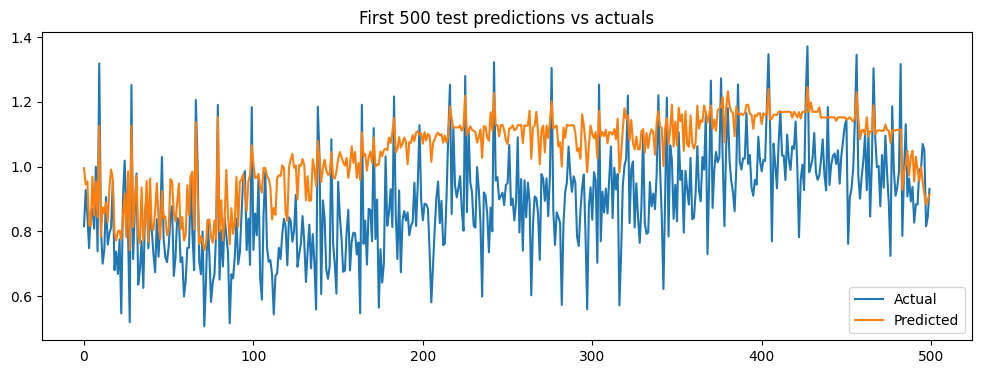

Test error l: 0.5012680831478631
Test error r: -0.008935777130654854
Test error m: 0.9341552947235756

Test Year: 2019 | Training Years: 2017 to 2018
Train samples: 413163 | Test samples: 221172


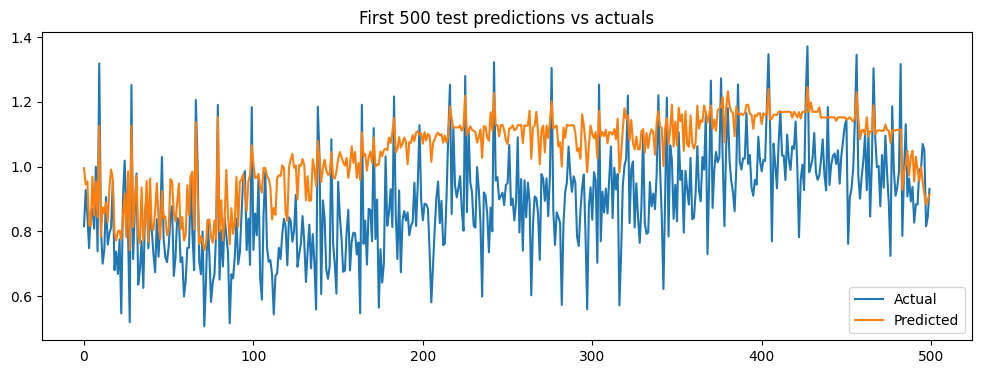

Test error l: 0.6310613732622734
Test error r: 0.17966047029050547
Test error m: 0.938860822081923

Test Year: 2020 | Training Years: 2018 to 2019
Train samples: 424380 | Test samples: 234675


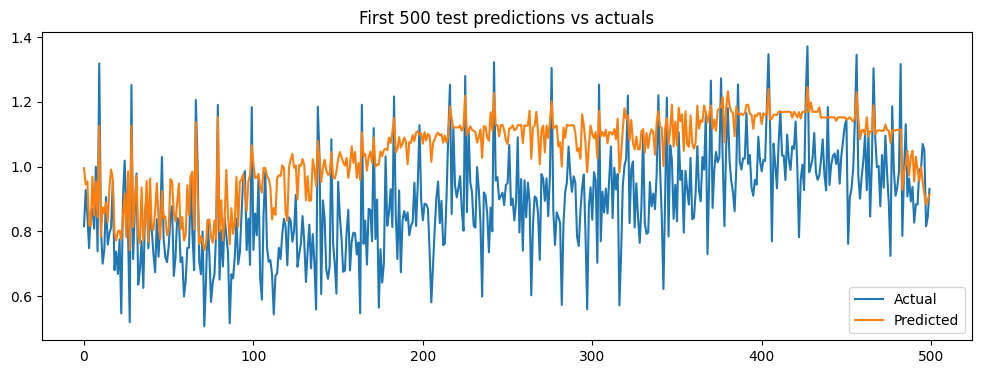

Test error l: 0.6148107687456598
Test error r: 0.03321041422254045
Test error m: 0.9380888664605121

Test Year: 2021 | Training Years: 2019 to 2020
Train samples: 455847 | Test samples: 252009


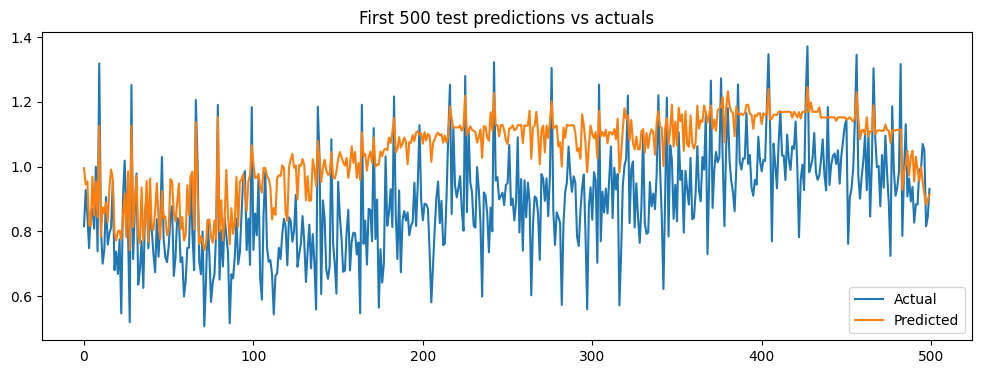

Test error l: 0.557618362107523
Test error r: -0.664929834146968
Test error m: 0.9383914413061423

Test Year: 2022 | Training Years: 2020 to 2021
Train samples: 486684 | Test samples: 282857


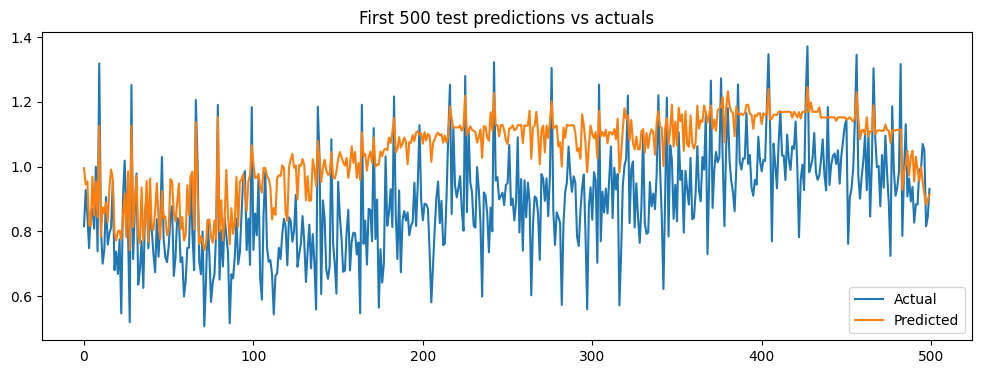

Test error l: 0.4536033318701743
Test error r: 0.3376747276159858
Test error m: 0.935826164570854

Test Year: 2023 | Training Years: 2021 to 2022
Train samples: 534866 | Test samples: 289771


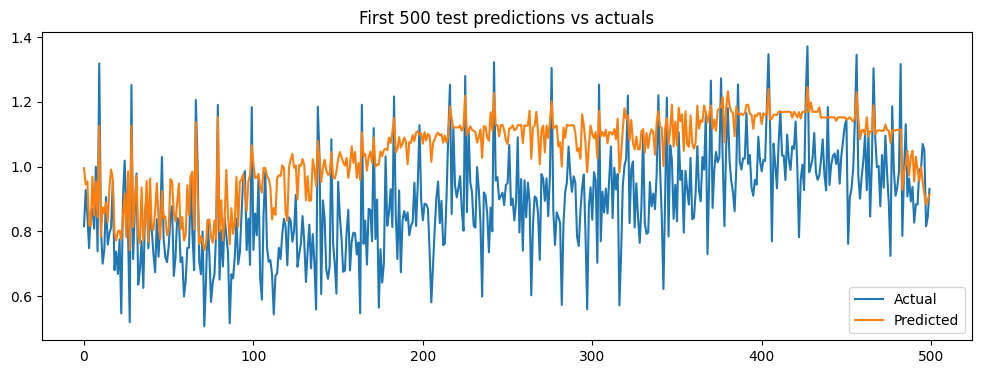

Test error l: 0.5322787201088517
Test error r: 0.15706386386204196
Test error m: 0.9381685672965049

Test Year: 2024 | Training Years: 2022 to 2023
Train samples: 572628 | Test samples: 303966


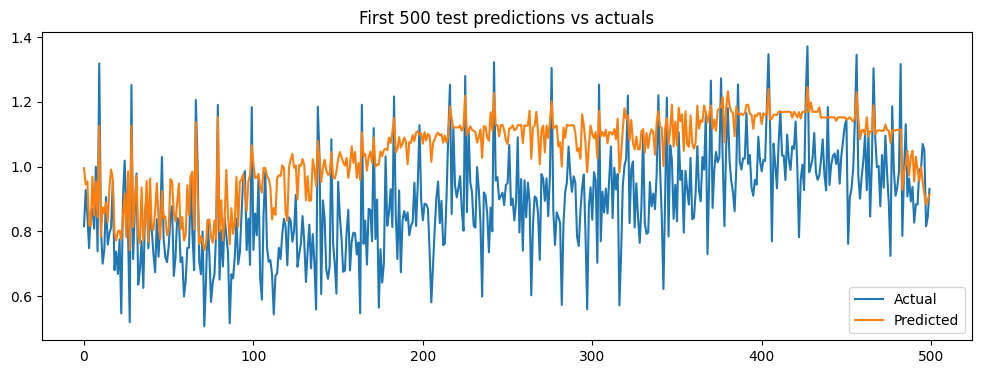

Test error l: 0.5726241018999951
Test error r: 0.12657117751692892
Test error m: 0.9316081632479674
Overall Train Metrics:
MAE: 0.08742259122124188, RMSE: 0.1120928520917678, R²: 0.6575345061512816
Overall Test Metrics:
MAE: 0.10025662146765735, RMSE: 0.12962850575109575, R²: 0.5581058685109672
================== DoubleMLPLIV Object ==================

------------------ Data summary      ------------------
Outcome variable: consumption_normalized
Treatment variable(s): ['DayAheadPriceEUR']
Cluster variable(s): ['Country']
Covariates: ['block_1.0:tempbin', 'block_6.0:tempbin2', 'block_1.0:tempbin2', 'block_6.0:tempbin', 'Month_1', 'Month_2', 'HourOfWeek_149', 'Month_5', 'HourOfWeek_150', 'HourOfWeek_125', 'HourOfWeek_151', 'Month_12', 'HourOfWeek_157', 'HourOfWeek_158', 'HourOfWeek_156', 'HourOfWeek_159', 'HourOfWeek_126', 'HourOfWeek_153', 'HourOfWeek_155', 'HourOfWeek_154', 'HourOfWeek_164', 'Month_3', 'HourOfWeek_140', 'HourOfWeek_152', 'block_3.0:tempbin', 'HourOfWeek_56', 'HourOfW

In [ ]:
dml_pliv_obj_lags_imp, filtered_data_lags_imp, importance_df_lags_imp, fold_metrics_df_lags_imp, importance_all_folds_df_lags_imp, fold_coefficients_lags_imp = dml_rolling_window(processed_data,
                                                                                                                             important_features,
                                                                                                                             dependent_variable = 'consumption_normalized',
                                                                                                                             manual_params_l=manual_params_l,
                                                                                                                             manual_params_r=manual_params_r,
                                                                                                                             manual_params_m=manual_params_m)


In [ ]:
filtered_data_lags_imp.to_csv("second_model_lags_importance.csv", index=False)
importance_df_lags_imp.to_csv("second_model_lags_importance_df_importance.csv", index=False)
fold_coefficients_lags_imp = pd.DataFrame(fold_coefficients_lags_imp)
fold_coefficients_lags_imp.to_csv("second_model_lags_fold_coefficients_lags_imp_1.csv", index=False)